<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [1]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11440769612449927365
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13896777728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5614147891620718812
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Clear all previous Keras sessions
tf.keras.backend.clear_session()

In [4]:
tf.keras.mixed_precision.set_global_policy('float32')
print(f"Mixed precision policy: {tf.keras.mixed_precision.global_policy()}")

Mixed precision policy: <Policy "float32">


## Data Loading

Load images and respective labels

In [5]:
base_dir = r"C:\Users\Blix\Downloads\Data"

In [6]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [7]:
image_height = 224
image_width = 224
batch_size = 64
seed = 42 # For reproducibility

In [8]:
all_image_paths = []
all_labels = []

## Data Split

In [9]:
grouped_styles = [
    'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [10]:
num_classes = len(grouped_styles)

In [11]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [12]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)

## Data Augmentation

In [13]:
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Changed from "horizontal_and_vertical"
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(0.2)
], name='data_augmentation')

In [14]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png if your images are PNG
    img = tf.image.resize(img, [image_height, image_width], method='bicubic')
    img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE) # Apply augmentation
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 56987
Number of validation samples: 12211
Number of test samples: 12212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024400085..1.0303811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0056851].


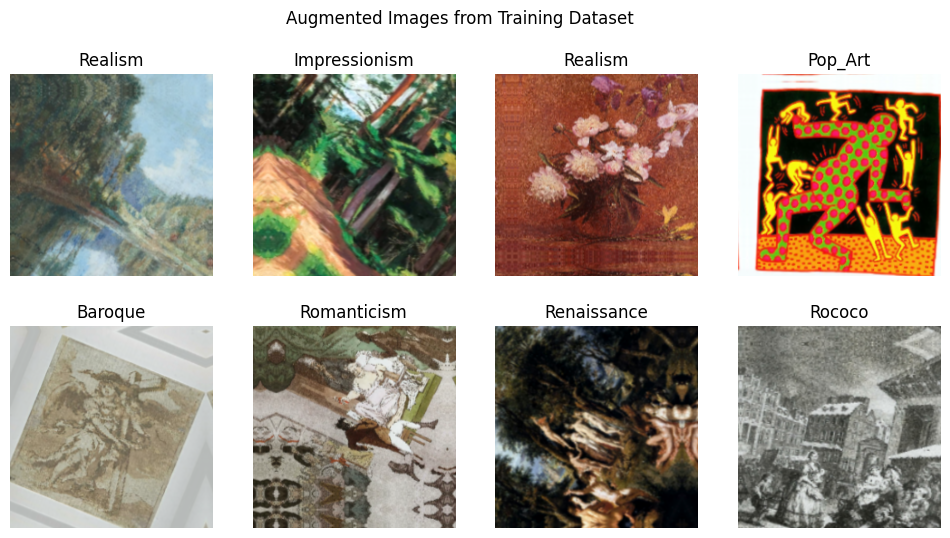

In [17]:
# Display a batch of augmented images from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = np.argmax(labels[i].numpy())
        plt.title(f"{grouped_styles[label_idx]}")
        plt.axis("off")
    plt.suptitle("Augmented Images from Training Dataset")
    plt.show()

## Rebalancing of Weights to match imbalanced art styles

In [18]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art_Nouveau_Modern (Index 0): Weight 1.1739
  Class Baroque (Index 1): Weight 1.2000
  Class Color_Field_Painting (Index 2): Weight 3.1519
  Class Cubism (Index 3): Weight 1.9864
  Class Expressionism (Index 4): Weight 0.5302
  Class Fauvism (Index 5): Weight 5.4460
  Class Impressionism (Index 6): Weight 0.2543
  Class Minimalism (Index 7): Weight 3.8052
  Class Naive_Art_Primitivism (Index 8): Weight 2.1163
  Class Pop_Art (Index 9): Weight 3.4313
  Class Realism (Index 10): Weight 0.4413
  Class Renaissance (Index 11): Weight 0.7751
  Class Rococo (Index 12): Weight 2.4362
  Class Romanticism (Index 13): Weight 0.7250
  Class Symbolism (Index 14): Weight 1.1236
  Class Ukiyo_e (Index 15): Weight 4.3595


In [19]:
# Check how many for each class are in each dataset. Define each class from its original label
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art_Nouveau_Modern): 3034 samples
Class 1 (Baroque): 2968 samples
Class 2 (Color_Field_Painting): 1130 samples
Class 3 (Cubism): 1793 samples
Class 4 (Expressionism): 6717 samples
Class 5 (Fauvism): 654 samples
Class 6 (Impressionism): 14007 samples
Class 7 (Minimalism): 936 samples
Class 8 (Naive_Art_Primitivism): 1683 samples
Class 9 (Pop_Art): 1038 samples
Class 10 (Realism): 8070 samples
Class 11 (Renaissance): 4595 samples
Class 12 (Rococo): 1462 samples
Class 13 (Romanticism): 4913 samples
Class 14 (Symbolism): 3170 samples
Class 15 (Ukiyo_e): 817 samples


## Model Training

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [37]:
model = tf.keras.Sequential([
    # First block with batch normalization
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4), input_shape=(image_height, image_width, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    
    # Second block
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.3),
    
    # Third block
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.3),
    
    # Fourth block
    tf.keras.layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    
    # Dense layers
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(styles), activation='softmax', dtype = 'float32')
])

In [38]:
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0

In [39]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [40]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 20,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-5,
)

In [41]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=1e-5,
    verbose=1
)

In [42]:
# Clear any previous Keras sessions
tf.keras.backend.clear_session()

In [43]:
# Generate focal loss function with class weights
def generate_focal_loss_with_weights(class_weights):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = tf.pow(1 - y_pred, 2.0)  # gamma=2.0

        # Apply class weights
        alpha_tensor = tf.constant(class_weights, dtype=tf.float32)
        alpha_factor = tf.reduce_sum(alpha_tensor * y_true, axis=-1, keepdims=True)
        weights *= alpha_factor

        focal_loss = weights * cross_entropy
        return tf.reduce_sum(focal_loss, axis=1)
    return focal_loss

In [ ]:
# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,
)

Epoch 1/1000
208/891 [======>.......................] - ETA: 4:20 - loss: 3.5625 - accuracy: 0.0952

## Model Evaluation

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

In [ ]:
# Plot Loss Graphs
plot_history(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('style_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
model.save('style_classification_model.h5')


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=styles))

In [ ]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()